<a href="https://colab.research.google.com/github/a-nagar/vistra-intermediate/blob/main/SARIMA_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARIMA and SARIMA Models

In this notebook, we will use data about industrial production from Federal Reserve Bank of St. Louis and try to model it as a time series.

In [ ]:
!pip install sktime seaborn matplotlib pandas statsmodels pmdarima

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Install the sktime library

In [ ]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 9.1 MB/s eta 0:00:00


In [ ]:
import sktime
from matplotlib import pyplot
import matplotlib as plt
import seaborn
import datetime
import pandas as pd
import statsmodels

We will load the data which can also be seen on the Federal Bank of St. Louis website at: https://fred.stlouisfed.org/graph/?g=1NUnf

In [ ]:
url = "https://raw.githubusercontent.com/a-nagar/vistra-intermediate/refs/heads/main/datasets/time-series/industrial_production.csv"

In [ ]:
# change for your uploaded URL
df = pd.read_csv(url, parse_dates=['observation_date'])
df.columns = ['date', 'production']
df['date'] = pd.to_datetime(df['date'])
df = df.set_index(df['date']).drop('date', axis=1)
df.head()

,production
date,
1939-01-01,3.3336
1939-02-01,3.3591
1939-03-01,3.4354
1939-04-01,3.4608
1939-05-01,3.4608


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1023 entries, 1939-01-01 to 2024-03-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   production  1023 non-null   float64
dtypes: float64(1)
memory usage: 16.0 KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
production,1023.0,56.492136,35.872999,3.3336,20.65055,56.7497,89.33245,126.3772


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='production'>)

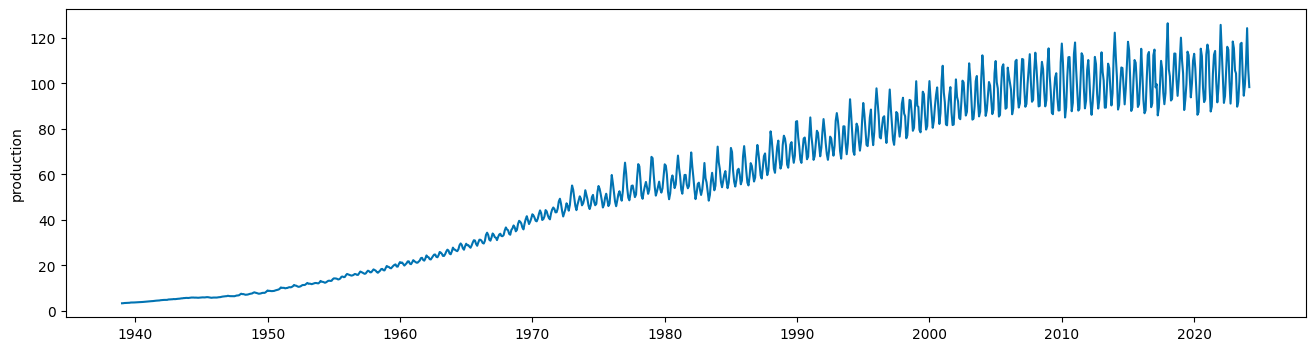

In [ ]:
from sktime.utils.plotting import plot_series
plot_series(df, markers=' ')

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df)
print(adf_result[1])

0.8064038372457284


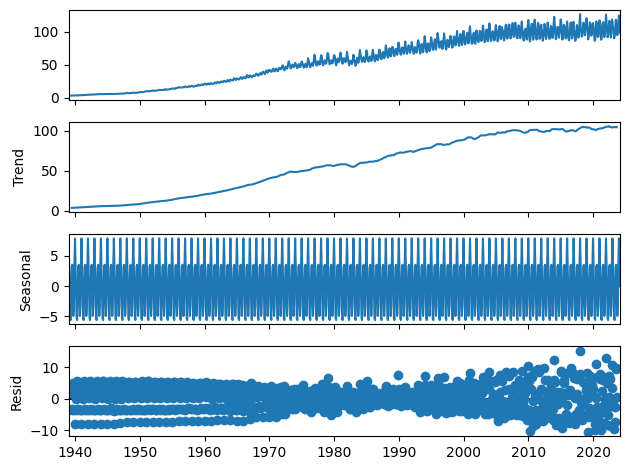

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df, model='additive')
result.plot()
pyplot.show()

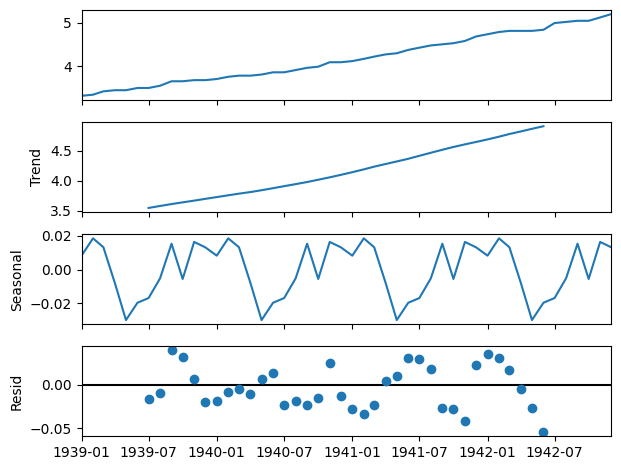

In [ ]:
result = seasonal_decompose(df[:48], model='additive')
result.plot()
pyplot.show()

In [ ]:
from sktime.split import temporal_train_test_split
train, test = temporal_train_test_split(df, test_size=36)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

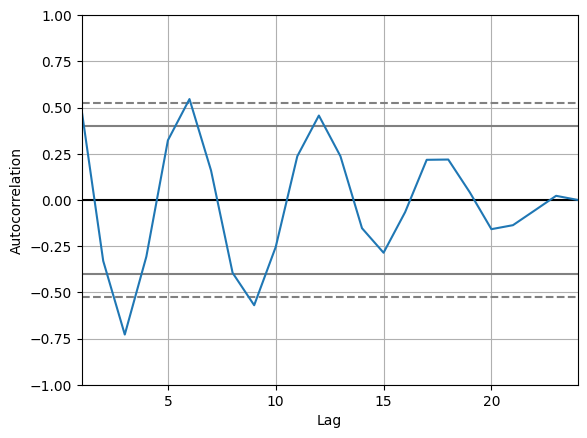

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(train[-24:])

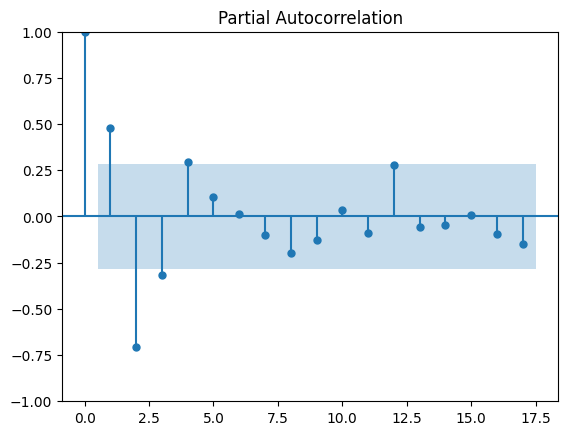

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(train[-48:])
pyplot.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(3,1,0))
model_fit = model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  987
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -2540.767
Date:                Fri, 14 Nov 2025   AIC                           5089.534
Time:                        16:37:15   BIC                           5109.108
Sample:                    01-01-1939   HQIC                          5096.979
                         - 03-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2140      0.016     13.410      0.000       0.183       0.245
ar.L2         -0.2811      0.014    -20.569      0.000      -0.308      -0.254
ar.L3         -0.5986      0.014    -41.383      0.0

In [ ]:
history = train
predictions = list()
# walk-forward validation
for t in range(len(test),0,-1):
    model = ARIMA(df[:-t], order=(3,1,0));
    model_fit = model.fit();
    output = model_fit.forecast();
    yhat = output.iloc[0]
    predictions.append(yhat)

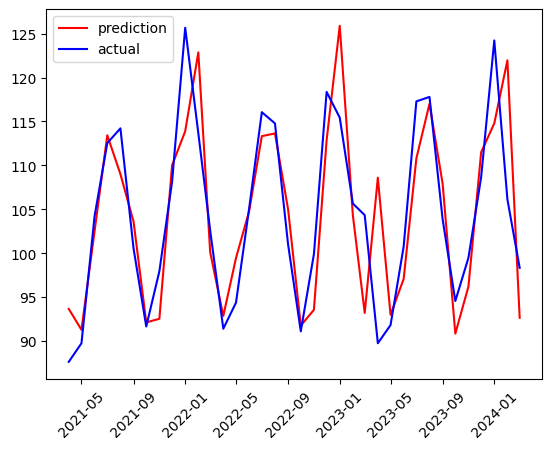

In [ ]:
test.loc[:,'predictions'] = predictions.copy()

pyplot.plot(test['predictions'], color='red', label='prediction')
pyplot.plot(test['production'], color='blue', label='actual')
pyplot.legend(loc="upper left")
pyplot.xticks(rotation=45)
pyplot.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# evaluate forecasts
rmse = sqrt(mean_squared_error(test['predictions'], test['production']))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 6.533


In order to find best parameters, we will use the pmdarima library and auto_arima function. It may take a while, so please be patient.

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 7.9 MB/s eta 0:00:00


In [ ]:
import pmdarima as pm

auto_model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      m=12, # frequency of series
                      d=None, # let model determine 'd'
                      seasonal=True, # Use Seasonality
                      information_criterion='aicc',
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

In [ ]:
print(auto_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  987
Model:             SARIMAX(1, 1, 1)x(2, 0, [1, 2], 12)   Log Likelihood               -1984.750
Date:                                 Fri, 14 Nov 2025   AIC                           3983.499
Time:                                         16:45:31   BIC                           4017.755
Sample:                                     01-01-1939   HQIC                          3996.528
                                          - 03-01-2021                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5296      0.022     24.042      0.000       0.486       0

In [ ]:
history = train
auto_predictions = auto_model.predict(len(test))

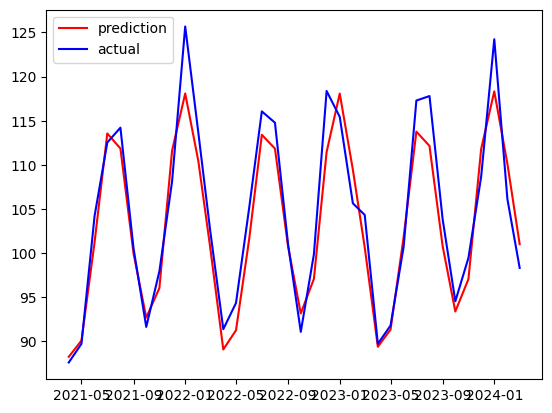

In [ ]:
test.loc[:, 'auto_predictions'] = auto_predictions.copy()

pyplot.plot(test['auto_predictions'], color='red', label='prediction')
pyplot.plot(test['production'], color='blue', label='actual')
pyplot.legend(loc="upper left")
pyplot.show()